# US Poverty Level impact on Hospital Bed Utilization. #

## by Jagadeesh Josyula ##

## Preliminary Wrangling

To analyze the impact of <b>poverty level on hospital bed utilization </b>the below two datasets will be used. <br>
US Hospital Beds dataset provides data critical for understanding the impact of high utilization. <br>
USDA provides socioeconomic indicators such as county level population poverty levels. <br>
<br>
Exploring a dataset containing bed utilization and poverty level for 6621 hospitals across all US counties.

In [1]:
# Import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import PercentFormatter
import seaborn as sb
import os
import wget

%matplotlib inline

In [2]:
# Setting up Plot style
plt.style.use({'figure.facecolor':'white'})


Loading Hospital and Bed dataset from the below sources.

**Hospital Bed Data Source:** https://opendata.arcgis.com/datasets/1044bb19da8d4dbfb6a96eb1b4ebf629_0.csv 

**US Poverty Level Data Source:**
https://www.ers.usda.gov/webdocs/DataFiles/48747/PovertyEstimates.xls <br>
Loading dataset and describe its properties through the questions below.
Try and motivate your exploration goals through this section.


In [3]:
# Loading dataset using a common functions.
def fetchdataset(filename, fileurl):
    if not os.path.exists(filename) :
        try:
            wget.download(fileurl, filename)
        except Exception as exception_object:
            print("Unexpected Exception:", exception_object)

hospital_beds_src = 'https://opendata.arcgis.com/datasets/1044bb19da8d4dbfb6a96eb1b4ebf629_0.csv'
usda_poverty_level_src = 'https://www.ers.usda.gov/webdocs/DataFiles/48747/PovertyEstimates.xls'
hospital_beds_file = 'hospital-beds.csv'
usda_poverty_level_file = 'usda_poverty.xls'
fetchdataset(hospital_beds_file, hospital_beds_src)
fetchdataset(usda_poverty_level_file, usda_poverty_level_src)

In [4]:
# Load data to dataframe
beds_df = pd.read_csv(hospital_beds_file)
usda_poverty_df = pd.read_excel(usda_poverty_level_file, sheet_name="Poverty Data 2018", skiprows=4)

In [5]:
# High-level overview of data shape and composition of hospital beds data.
print(beds_df.shape)
print(beds_df.dtypes)
print(beds_df.head())

(6621, 23)
X                                  float64
Y                                  float64
OBJECTID                             int64
HOSPITAL_NAME                       object
HOSPITAL_TYPE                       object
HQ_ADDRESS                          object
HQ_ADDRESS1                         object
HQ_CITY                             object
HQ_STATE                            object
HQ_ZIP_CODE                          int64
COUNTY_NAME                         object
STATE_NAME                          object
STATE_FIPS                         float64
CNTY_FIPS                          float64
FIPS                               float64
NUM_LICENSED_BEDS                  float64
NUM_STAFFED_BEDS                   float64
NUM_ICU_BEDS                         int64
ADULT_ICU_BEDS                       int64
PEDI_ICU_BEDS                      float64
BED_UTILIZATION                    float64
Potential_Increase_In_Bed_Capac      int64
AVG_VENTILATOR_USAGE               float64


In [6]:
# High-level overview of data shape and composition of US Poverty level data.
print(usda_poverty_df.shape)
print(usda_poverty_df.dtypes)
print(usda_poverty_df.head())

(3193, 34)
FIPStxt                              int64
Stabr                               object
Area_name                           object
Rural-urban_Continuum_Code_2003    float64
Urban_Influence_Code_2003          float64
Rural-urban_Continuum_Code_2013    float64
Urban_Influence_Code_2013          float64
POVALL_2018                          int64
CI90LBAll_2018                       int64
CI90UBALL_2018                       int64
PCTPOVALL_2018                     float64
CI90LBALLP_2018                    float64
CI90UBALLP_2018                    float64
POV017_2018                          int64
CI90LB017_2018                       int64
CI90UB017_2018                       int64
PCTPOV017_2018                     float64
CI90LB017P_2018                    float64
CI90UB017P_2018                    float64
POV517_2018                          int64
CI90LB517_2018                       int64
CI90UB517_2018                       int64
PCTPOV517_2018                     float64


**Hospital Beds Data** 


Data shape and features: There are 23 features in total, with 6621 rows. The dataframe shows there is opportunity to wrangle to make it more usable. Cleaning and enriching of features were performed to achive our goal. 

Data Wrangling: Cleaning the data set to remove dirty and inconsistent data.

In [7]:
null_columns = beds_df.columns[beds_df.isnull().any()]
beds_df[null_columns].isnull().sum()


X                         18
Y                         18
HQ_ADDRESS1             6253
COUNTY_NAME               25
STATE_NAME                25
STATE_FIPS                25
CNTY_FIPS                 25
FIPS                      25
NUM_LICENSED_BEDS        148
NUM_STAFFED_BEDS         236
PEDI_ICU_BEDS            737
BED_UTILIZATION          711
AVG_VENTILATOR_USAGE      75
dtype: int64

In [8]:
# Hospitals that did not report bed utilization will be dropped. Since we cannot impute a value.
beds_df = beds_df.dropna(subset=['BED_UTILIZATION'])

In [9]:
# 25 Hospitals did not report on county, fips, state name information. We drop these rows too.
beds_df = beds_df.dropna(subset=['FIPS'])


In [10]:
# We can assign 0 values to columns "PEDI_ICU_BEDS" and "AVG_VENTILATOR_USAGE" as safe defaults.
beds_df.PEDI_ICU_BEDS.fillna(0, inplace=True)
beds_df.AVG_VENTILATOR_USAGE.fillna(0.0, inplace=True)

In [11]:
#Setting blank value to "ADDRESS1" column where the address line1 is null.
beds_df.HQ_ADDRESS1.fillna('', inplace=True)

In [12]:
# Let's rename the "Potential_Increase_In_Bed_Capac" column.
beds_df.rename(columns={"Potential_Increase_In_Bed_Capac": "POTNL_INC_BED_CAPC"}, inplace=True)

**Hospital Beds Data**  

Data Wrangling: Enriching the data set by supplementing additional features.

In [13]:
# Creating additional feature to represent Percentage of Beds utilized from "BED_UTILIZATION" feature.
# "BED_UTILIZATION" ratio - will be analyzed as percentage so we have normalized measures.
beds_df['PCT_BED_UTILIZATION'] = beds_df[['BED_UTILIZATION']]*100

In [14]:
# Creating additional feature to represent percentage increase in potential increase in bed availability.
# "POTNL_INC_BED_CAPC" will be analyzed as percentage so we have normalized measures.

beds_df['PCT_POTNL_INC_BED_CAPC'] = beds_df['POTNL_INC_BED_CAPC']/\
                                    (beds_df['NUM_STAFFED_BEDS'] + beds_df['POTNL_INC_BED_CAPC'])*100

**Hospital Beds Data** 


Data Wrangling: Structuring the data set to be suitable for machine learning.

In [15]:
# Changing the data types of "STATE_FIPS", "CNTY_FIPS", "FIPS" from float data type to int64 type.
# County FIPS are never represented as decimal values rather as whole number.
beds_df[['STATE_FIPS', 'CNTY_FIPS', 'FIPS']] = beds_df[['STATE_FIPS', 'CNTY_FIPS', 'FIPS']].astype('int64')

**US Poverty level Data**

Data shape and features: There are 34 features in total, with 3193 rows. The dataframe shows there is opportunity to wrangle to make it more usable.

Data Wrangling: Cleaning the data set to remove dirty and inconsistent data.


In [16]:
# Rename the "FIPStxt" feature to be consistent with "Hospital Bed Data".
# We want to use the FIPS column to merge both hospital and poverty level data.
usda_poverty_df.rename(columns={"FIPStxt": "FIPS"}, inplace=True)

In [17]:
# We will rename the "PCTPOVALL_2018" column to be consistent with columns representing the percentage values.
# All percentage columns are named using "PCT_" prefix.
usda_poverty_df.rename(columns={"PCTPOVALL_2018": "PCT_POVALL_2018"}, inplace=True)

## What is/are the main feature(s) of interest in the datasets?##


**Hospital Beds Data**


The most intresting features that could help analyze and recommend federal agencies augment health workers where demand and resource capacity exist.

The percentages of bed utilization, potential increase in bed capacity, hospital types where the demand and resource capacity exists. **Feature names: "PCT_BED_UTILIZATION", "PCT_POTNL_INC_BED_CAPC", "HOSPITAL_TYPE".**

**US Poverty level Data**

Socioeconomic status - such as populations living in federal poverty is the key feature that this data set provides.
Feature names: "FIPS", "PCT_POVALL_2018" (Estimated percent of people of all ages in poverty 2018) is the feature that is going to be used.


Enriching the dataset by combining hospital beds data with poverty level data. </br>

We join the datasets by using "FIPS" as we are focused in the poverty level of population associated with hopsital beds utilization.

In [18]:
# We are only interested in "FIPS" and "PCT_POVALL_2018"
us_poverty_df = usda_poverty_df[['FIPS', 'PCT_POVALL_2018']]

In [19]:
#Merged Master DataFrame
beds_poverty_df = beds_df.merge(us_poverty_df, on='FIPS')

In [20]:
# Taking a peek at the the combined master data set.
print(beds_poverty_df.shape)
print(beds_poverty_df.dtypes)
print(beds_poverty_df.head())

(5849, 26)
X                         float64
Y                         float64
OBJECTID                    int64
HOSPITAL_NAME              object
HOSPITAL_TYPE              object
HQ_ADDRESS                 object
HQ_ADDRESS1                object
HQ_CITY                    object
HQ_STATE                   object
HQ_ZIP_CODE                 int64
COUNTY_NAME                object
STATE_NAME                 object
STATE_FIPS                  int64
CNTY_FIPS                   int64
FIPS                        int64
NUM_LICENSED_BEDS         float64
NUM_STAFFED_BEDS          float64
NUM_ICU_BEDS                int64
ADULT_ICU_BEDS              int64
PEDI_ICU_BEDS             float64
BED_UTILIZATION           float64
POTNL_INC_BED_CAPC          int64
AVG_VENTILATOR_USAGE      float64
PCT_BED_UTILIZATION       float64
PCT_POTNL_INC_BED_CAPC    float64
PCT_POVALL_2018           float64
dtype: object
           X          Y  OBJECTID  \
0 -90.105308  32.325487        10   
1 -90.101250  32.

## What features in the dataset will help support our investigation the feature(s) of interest?##


I expect the bed utilization, potential increase in bed, poverty level associated with county where the hospital's are located, and the hospital type will have effect on recommendation that help federal agencies support and augment health workers where demand exists.


## Univariate Exploration ##

I'll start by looking at the distribution of the main variable of interest.

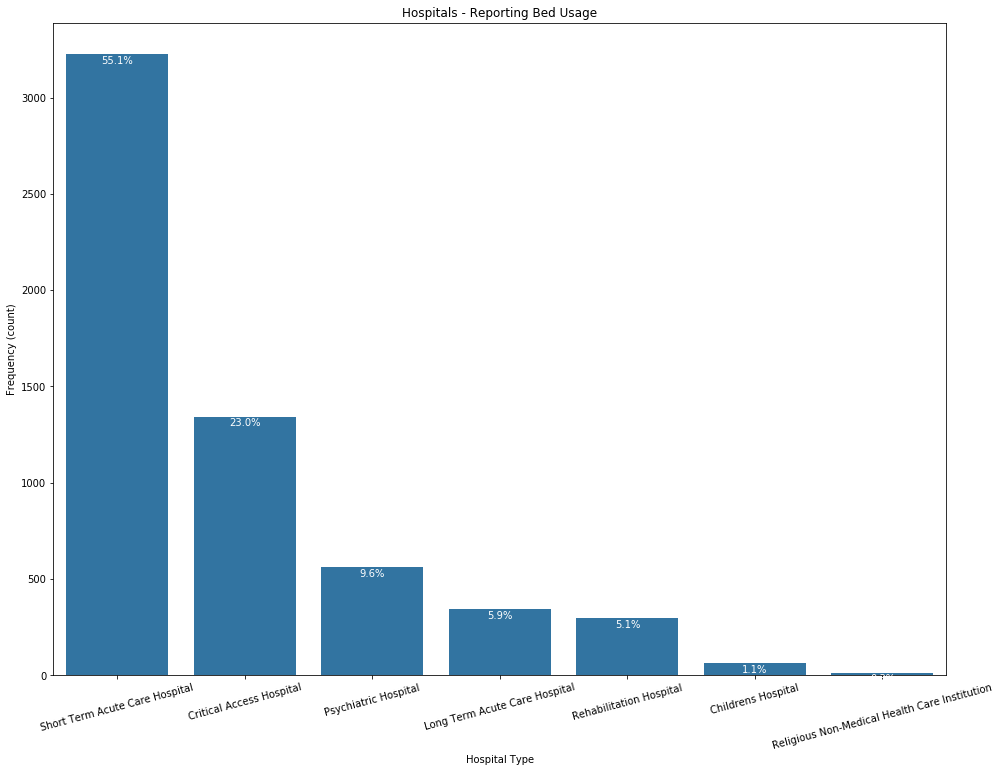

In [21]:
# Question: Which hospitals types are reporting their bed utilizations.
plt.figure(figsize=[16, 12])

base_color = sb.color_palette()[0]
sb.countplot(data=beds_poverty_df, x='HOSPITAL_TYPE', color=base_color)

# add annotations
n_points = beds_poverty_df.shape[0]
cat_counts = beds_poverty_df['HOSPITAL_TYPE'].value_counts()
locs, labels = plt.xticks() # get the current tick locations and labels
plt.xticks(rotation=15)
plt.xlabel("Hospital Type")
plt.ylabel("Frequency (count)")
plt.title("Hospitals - Reporting Bed Usage")

# loop through each pair of locations and labels
for loc, label in zip(locs, labels):

    # get the text property for the label to get the correct count
    count = cat_counts[label.get_text()]
    pct_string = '{:0.1f}%'.format(100*count/n_points)

    # print the annotation just below the top of the bar
    plt.text(loc, count-50, pct_string, ha = 'center', color = 'w')

plt.rcParams["axes.labelsize"] = 15
plt.show()



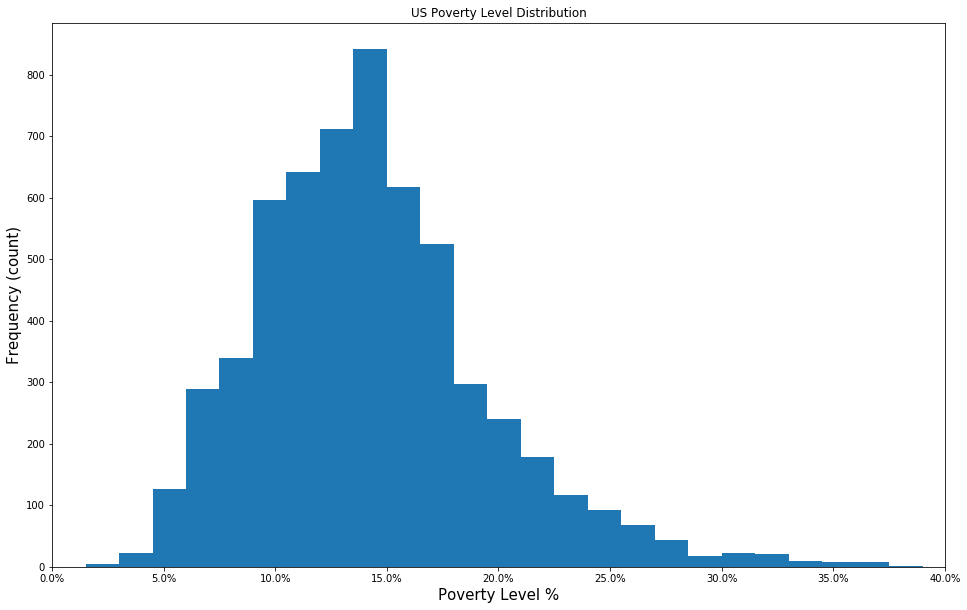

In [22]:
# Question: What is the poverty level distribution across all US counties.

fig, ax = plt.subplots(figsize = [16, 10])
#plt.figure(figsize = [16, 10])
bin_edges = np.arange(0, beds_poverty_df['PCT_POVALL_2018'].max()+1.5, 1.5)
ax.hist(data = beds_poverty_df, x = 'PCT_POVALL_2018', bins = bin_edges)
ax.set_xlim(0,40)
ax.xaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_xlabel('Poverty Level %')
ax.set_ylabel('Frequency (count)')
ax.set_title('US Poverty Level Distribution')
plt.rcParams["axes.labelsize"] = 10
plt.show()

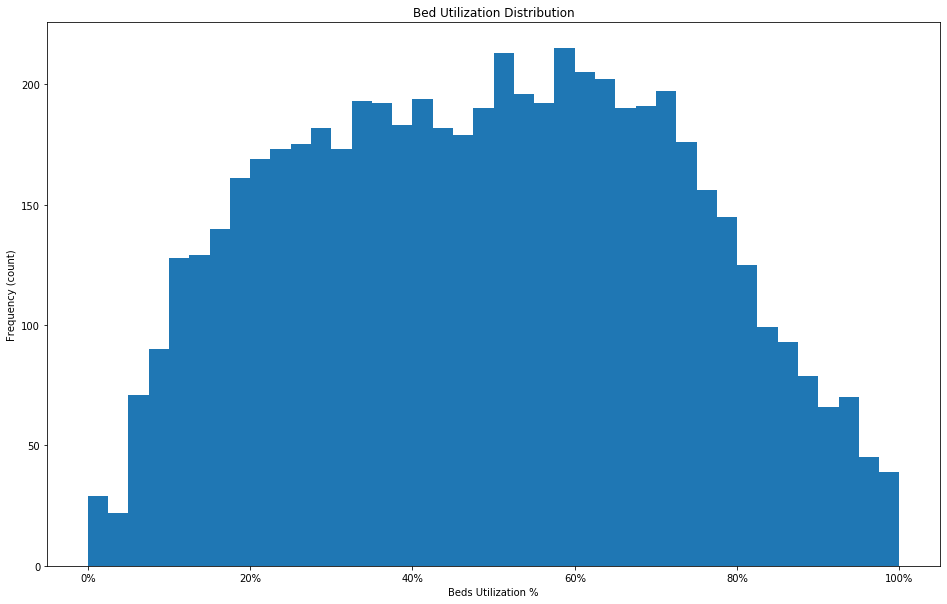

In [23]:
# Question: What is the bed utilization distribution across all US counties.
fig, ax = plt.subplots(figsize = [16,10])
bin_edges = np.arange(0, beds_poverty_df['PCT_BED_UTILIZATION'].max()+2.5, 2.5)
ax.hist(data = beds_poverty_df, x = 'PCT_BED_UTILIZATION', bins = bin_edges)
ax.set_xlabel('Beds Utilization %')
ax.set_ylabel('Frequency (count)')
ax.xaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_title('Bed Utilization Distribution')
plt.show()

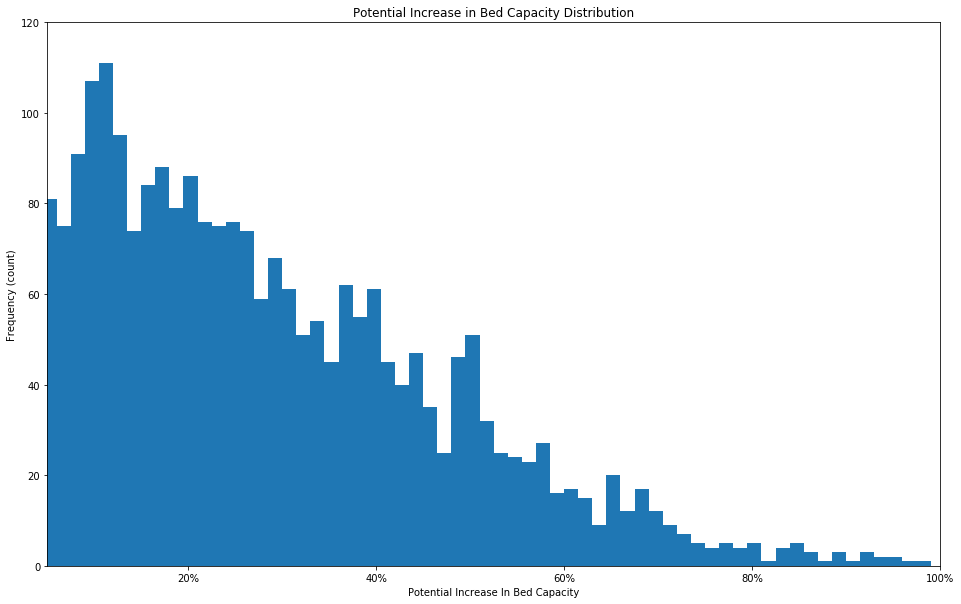

In [24]:
# Question: What is the potential bed capacity distribution across all US counties.
plt.figure(figsize = [16,10])
bin_edges = np.arange(0, beds_poverty_df['PCT_POTNL_INC_BED_CAPC'].max()+1.5, 1.5)
plt.hist(data= beds_poverty_df, x = 'PCT_POTNL_INC_BED_CAPC', bins=bin_edges)
plt.xlim([5, 100])
plt.ylim([0, 120])
plt.xlabel('Potential Increase In Bed Capacity')
plt.ylabel('Frequency (count)')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter())
plt.title('Potential Increase in Bed Capacity Distribution')
plt.rcParams["axes.labelsize"] = 10
plt.show()

In [25]:
beds_poverty_df[['PCT_POTNL_INC_BED_CAPC', 'PCT_BED_UTILIZATION', 'PCT_POVALL_2018']].describe()

,PCT_POTNL_INC_BED_CAPC,PCT_BED_UTILIZATION,PCT_POVALL_2018
count,5849.000000,5849.000000,5849.000000
mean,9.063412,49.135749,14.245392
std,34.193950,23.574880,5.268514
min,-1210.000000,0.072098,2.600000
25%,0.000000,29.932964,10.600000
50%,0.000000,49.676713,13.800000
75%,20.087336,67.704111,16.800000
max,98.000000,100.000000,54.000000


In [26]:
beds_poverty_df[['PCT_POTNL_INC_BED_CAPC', 'PCT_BED_UTILIZATION', 'PCT_POVALL_2018']].mode()


,PCT_POTNL_INC_BED_CAPC,PCT_BED_UTILIZATION,PCT_POVALL_2018
0,0.0,100.0,14.2


## Observations of the Univariate distribution. ##
- **55%** of reported bed utilization are from <b>Short term acute care </b> hospital's followed by <b> Critical acute care </b> hospital's.
- A <b> slightly right skewed distribution </b> can be seen with US Poverty level. **14.2%** of average population living in poverty.
- Bed utilization tends to show two peaks, while the mean indicates a **49%** utilization. <br>
- Increase in bed capacity is right skewed, indicating the increased availability to be between **10 to 40%**.

## Of the features investigated, were there any unusual distributions? Did I perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this? ##


When investigating the hospital type, poverty level, bed utilization and potential increase in bed capacity - I found that the Short term acute care hospitals are the highest used in terms of bed utilization. 10 to 40% potential increase in bed capacity does provide a positive outlook. While I did see a negative drop in availability. I have only considered the increase in availability, as the goal was to build a resource recommendation model where availability exists.


## Bivariate Exploration ##

To start off with, I want to look at the pairwise correlations present between features in the data.

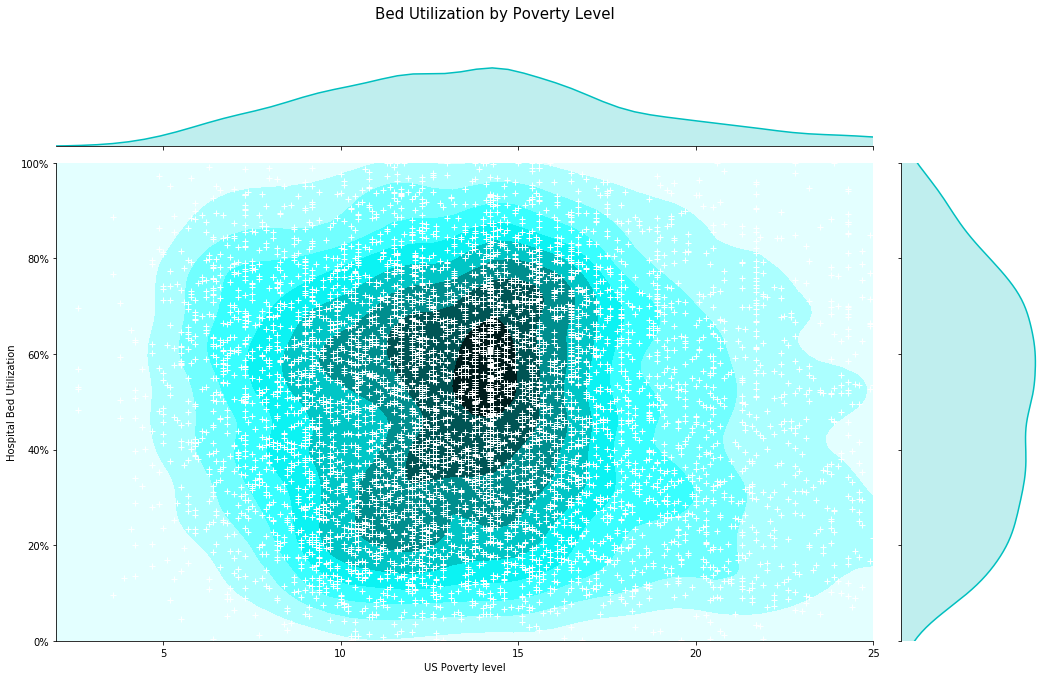

In [27]:
# How is bed utilization by the population with respect to poverty level?
g = sb.jointplot(x="PCT_POVALL_2018", y="PCT_BED_UTILIZATION", data=beds_poverty_df, kind="kde", color="c",
                 xlim=(2,25), ylim=(0,100))
g.plot_joint(plt.scatter, c="w", s=30, linewidth=1, marker="+")
g.set_axis_labels("US Poverty level", "Hospital Bed Utilization")
g.fig.set_figwidth(16)
g.fig.set_figheight(10)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.rcParams["axes.labelsize"] = 10
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Bed Utilization by Poverty Level', fontsize=15)
plt.show()

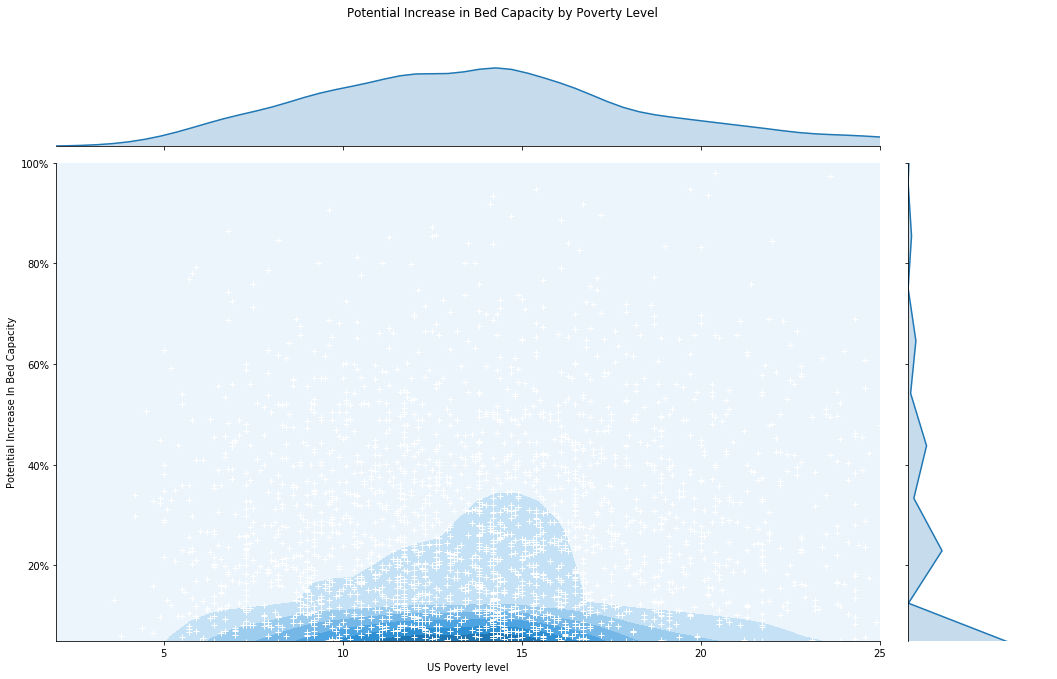

In [28]:
# What impact will the potential increase in bed capacity has on population living in poverty?
g = sb.jointplot(x="PCT_POVALL_2018", y="PCT_POTNL_INC_BED_CAPC", data=beds_poverty_df, kind="kde")
g.plot_joint(plt.scatter, c="w", s=30, linewidth=1, marker="+")
g.set_axis_labels("US Poverty level", "Potential Increase In Bed Capacity")
plt.xlim(2, 25)
plt.ylim(5, 100)
g.fig.set_figwidth(16)
g.fig.set_figheight(10)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.rcParams["axes.labelsize"] = 10
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Potential Increase in Bed Capacity by Poverty Level', fontsize=12)
plt.show()

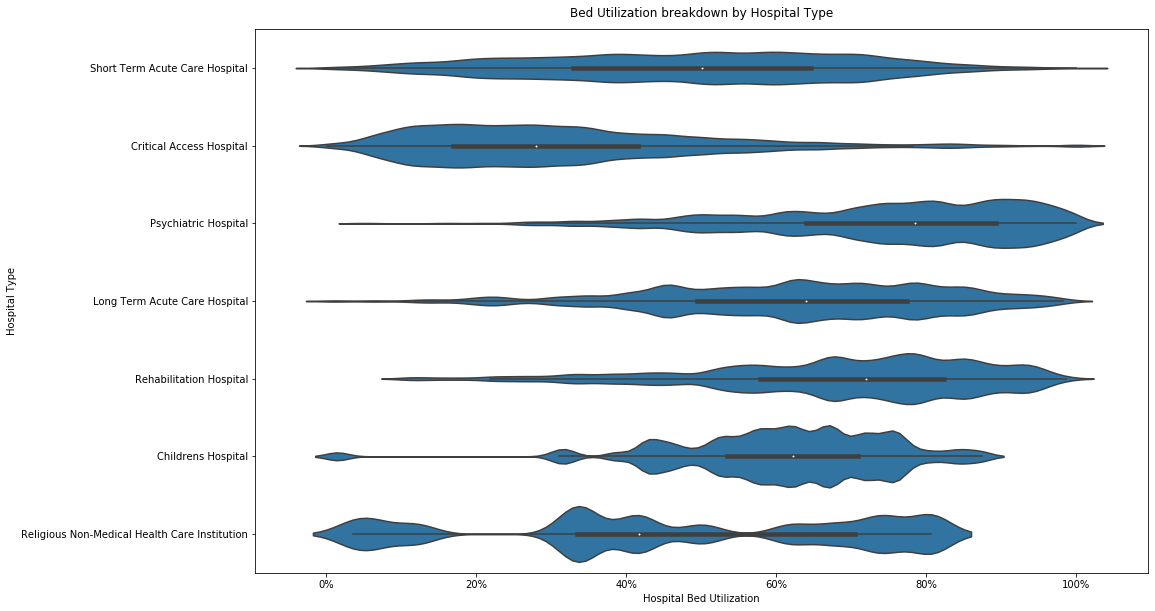

In [29]:
# Bed utilization breakdown by Hospital type, this helps us deliver better patient care.
fig,ax = plt.subplots(figsize = [16,10])
base_color = sb.color_palette()[0]
g = sb.violinplot(data = beds_poverty_df[beds_poverty_df['PCT_BED_UTILIZATION'] <=100], x = 'PCT_BED_UTILIZATION', y = 'HOSPITAL_TYPE', color = base_color, bw=.1)
#plt.xlim(0)
plt.xlabel("Hospital Bed Utilization")
plt.ylabel("Hospital Type")
plt.title('Bed Utilization breakdown by Hospital Type')
g.set_title('Bed Utilization breakdown by Hospital Type', fontdict={'fontsize':12}, pad=12)
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

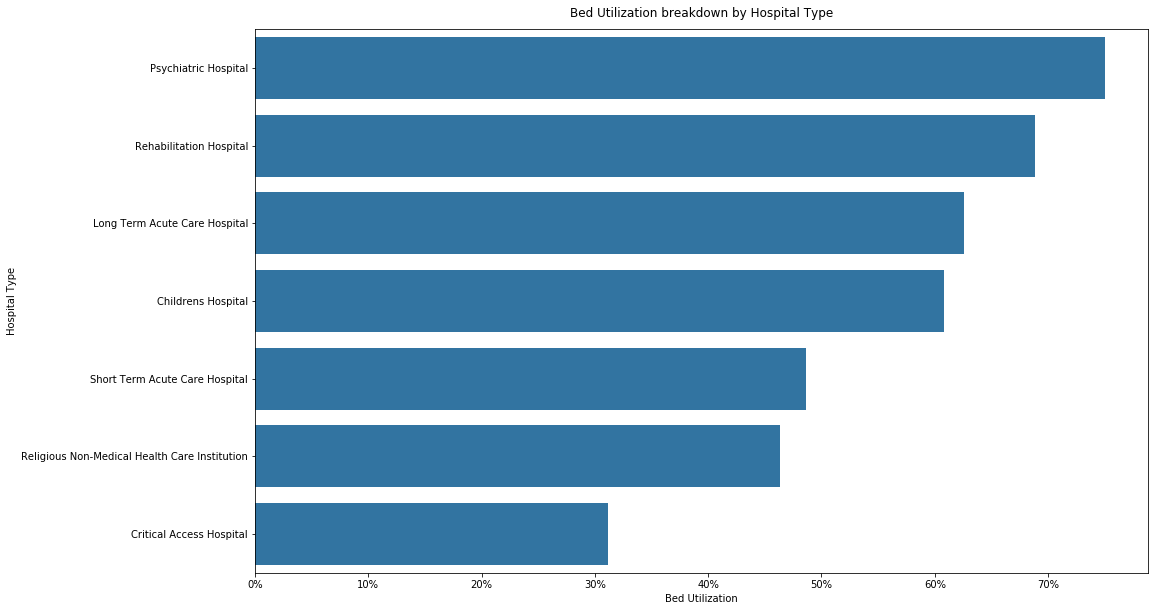

In [30]:
# Looking more closely at which hospital types were most utilized in terms of bed capacity.
plt.figure(figsize = [16,10])
# Ordered data frame
hosptl_bed_util_df = beds_poverty_df.groupby('HOSPITAL_TYPE')['PCT_BED_UTILIZATION'].agg(['mean']).sort_values(['mean'], ascending=False).reset_index().rename(columns={'mean' : 'PCT_BED_UTILIZATION'})

base_color = sb.color_palette()[0]
pct_bedsutil = sb.barplot(data=hosptl_bed_util_df, y='HOSPITAL_TYPE', x='PCT_BED_UTILIZATION', color=base_color, ci=None)
plt.xlim(0)
plt.xlabel("Bed Utilization")
plt.ylabel("Hospital Type")
#plt.title('Bed Utilization breakdown by Hospital Type')
pct_bedsutil.set_title('Bed Utilization breakdown by Hospital Type', fontdict={'fontsize':12}, pad=12)
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()


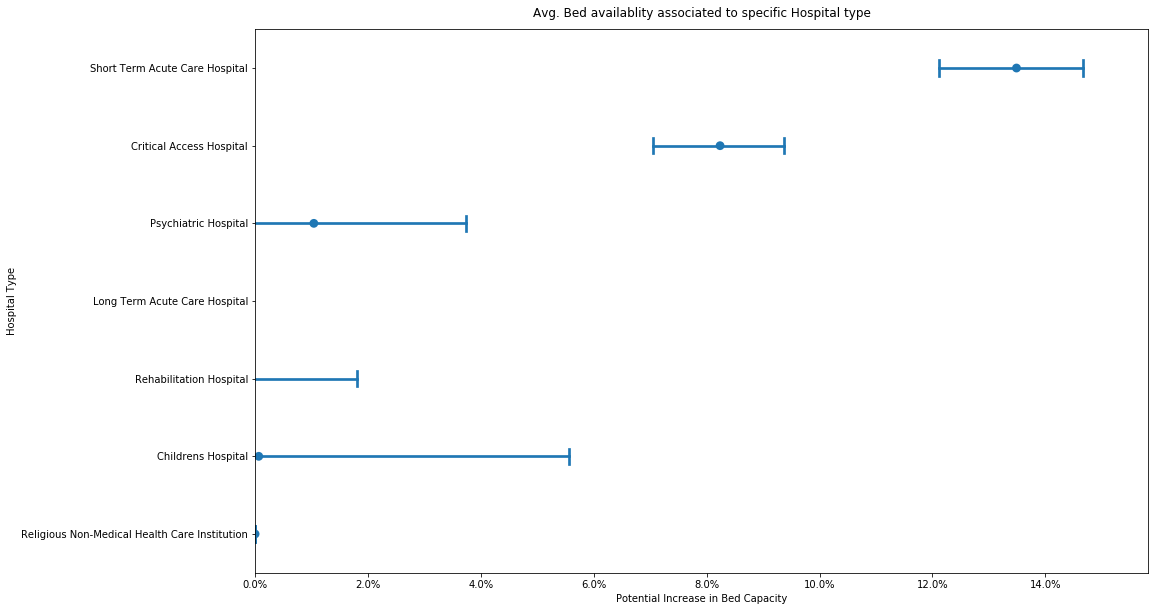

In [31]:
# To shows the hospital types that have the potential increase in bed capacity, I'm using pointplot, to plot the point estimate and confidence interval with connect points to show the bed availablity associated to specific hospital type.
fig,ax = plt.subplots(figsize = [16,10])
pct_pntplot = sb.pointplot(data = beds_poverty_df, y= 'HOSPITAL_TYPE', x ='PCT_POTNL_INC_BED_CAPC', capsize=.2, dodge=True, join=False)
ax.set(xlim=(0))
plt.xlabel("Potential Increase in Bed Capacity")
plt.ylabel("Hospital Type")
pct_pntplot.set_title('Avg. Bed availablity associated to specific Hospital type', fontdict={'fontsize':12}, pad=12)
#plt.title('Avg. Bed availablity associated to specific Hospital type')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

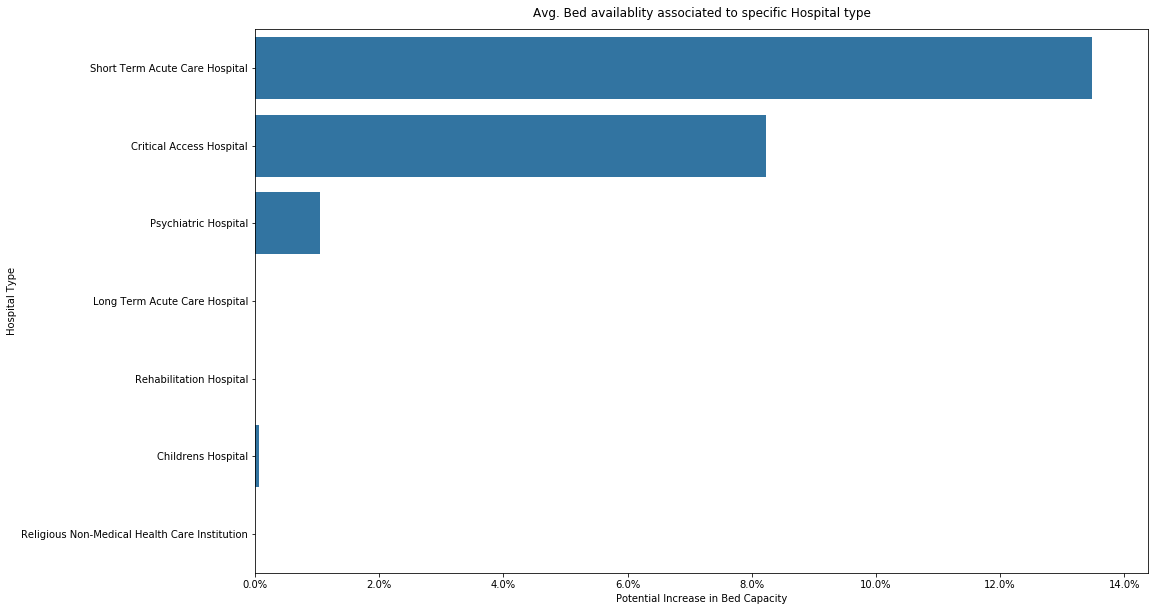

In [32]:
# Taking a closer look, using Bar chart - to show the hopsital types that have bed availability.
fig,ax = plt.subplots(figsize = [16,10])
base_color = sb.color_palette()[0]
pct_barplot = sb.barplot(data=beds_poverty_df, y='HOSPITAL_TYPE', x='PCT_POTNL_INC_BED_CAPC', color=base_color, ci=None,
         )
plt.xlim(0)
plt.xlabel("Potential Increase in Bed Capacity")
plt.ylabel("Hospital Type")
pct_barplot.set_title('Avg. Bed availablity associated to specific Hospital type', fontdict={'fontsize':12}, pad=12)
#plt.title('Avg. Bed availablity associated to specific Hospital type')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()


In [33]:
# Looking at the breakdown by Hospital type with respect to potential increase in bed 
beds_poverty_df.groupby('HOSPITAL_TYPE')['PCT_POTNL_INC_BED_CAPC'].agg(['mean']).sort_values(['mean'], ascending=False).reset_index().rename(columns={'mean' : 'PCT_POTNL_INC_BED_CAPC'})

,HOSPITAL_TYPE,PCT_POTNL_INC_BED_CAPC
0,Short Term Acute Care Hospital,13.488579
1,Critical Access Hospital,8.237320
2,Psychiatric Hospital,1.041122
3,Childrens Hospital,0.065167
4,Religious Non-Medical Health Care Institution,0.000000
5,Rehabilitation Hospital,-2.133959
6,Long Term Acute Care Hospital,-4.371247


In [34]:
# Looking at the breakdown by Hospital type with respect to bed utilization.
beds_poverty_df.groupby('HOSPITAL_TYPE')['PCT_BED_UTILIZATION'].agg(['mean']).sort_values(['mean'], ascending=False).reset_index().rename(columns={'mean' : 'PCT_BED_UTILIZATION'})


,HOSPITAL_TYPE,PCT_BED_UTILIZATION
0,Psychiatric Hospital,75.059067
1,Rehabilitation Hospital,68.820145
2,Long Term Acute Care Hospital,62.621047
3,Childrens Hospital,60.835327
4,Short Term Acute Care Hospital,48.659959
5,Religious Non-Medical Health Care Institution,46.355445
6,Critical Access Hospital,31.120385


In [35]:
# Subsetting data that is relevant to the problem we are solving.
pot_beds_df = beds_poverty_df.query(('PCT_BED_UTILIZATION >0 and  PCT_BED_UTILIZATION <=100') and ('PCT_POTNL_INC_BED_CAPC >0 and  PCT_POTNL_INC_BED_CAPC <=100'))

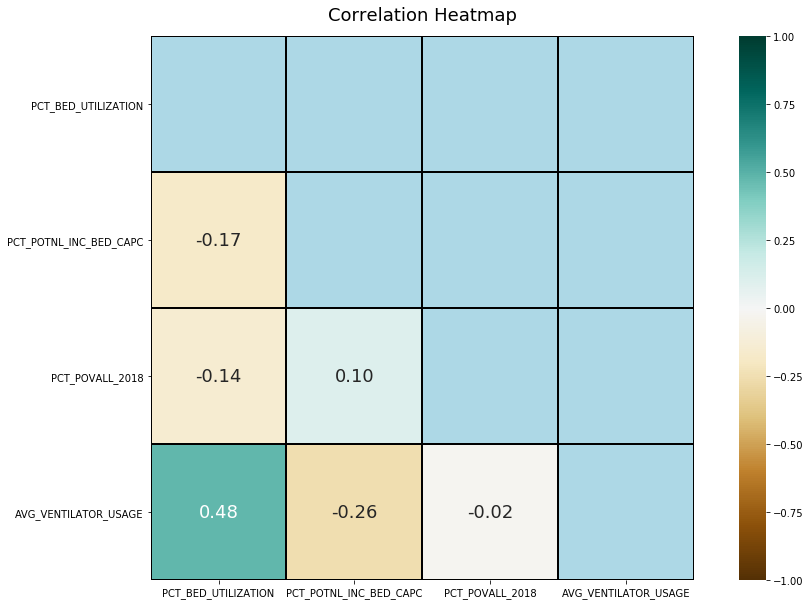

In [36]:
# What is the correlation between the features of intrest given that we have our data of intrest?
fig,ax = plt.subplots(figsize = [16,10])
matrix = np.triu(pot_beds_df[['PCT_BED_UTILIZATION', 'PCT_POTNL_INC_BED_CAPC', 'PCT_POVALL_2018', 'AVG_VENTILATOR_USAGE']].corr())
heatmap = sb.heatmap(pot_beds_df[['PCT_BED_UTILIZATION', 'PCT_POTNL_INC_BED_CAPC', 'PCT_POVALL_2018', 'AVG_VENTILATOR_USAGE']].corr(), annot = True, fmt = '.2f', annot_kws={"fontsize":18}, vmin=-1, vmax=1, center= 0, cmap='BrBG', linewidths=1, linecolor='black', square=True, mask = matrix)

heatmap.set_facecolor('lightblue')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=16)
plt.show()


## Bivariate Analysis Findings ##

### Analysis on Hospital Bed Utilization with reference to US Poverty Level ### 

- People living in counties near the poverty level between ** 10 - 18% ** is shown to have high bed utilization.
- A downword trend of Bed utilization is observed as the poverty level increases.
- Counties with poverty level outliers with a low of ** 2% ** and a high of ** 54% ** is observed.

### Analysis on Bed availability with reference to US Poverty Level ### 

- ** 20% ** of Potential increase in bed capacity is available for people living in counties near the poverty level between ** 10 - 18% **.
- A ** downword trend ** in bed availability is observed as we see a right skew in availability.
- We do see a negative availability of beds while on the postive side we have as high as 98% of availability.

### Analysis on Hospital Type with reference to Bed Utilization ###

- Psychiatric Hospital is the top hospital type in terms of bed utilization.
- Critical Access Hospital is the least in terms of bed utilization.
- Though Short Term Acute Care Hospitals was the highest reported dataset in terms of counts, the bed utilization is shy of ** 50% **.

### Analysis on Hospital Type with reference to Bed Availability ###

- Short Term Acute Care Hospitals at ** 13.48% ** - are the featured hosptilas that benefit with high bed availability.
- Long Term Acute Care Hospital at ** -4.37% ** - is shown to have shortage in bed availability.
- With just ** 0.065% ** of bed availability Childrens Hospitals are under served.
- Religious Non-Medical Health Care Institution	at ** 0% ** have no bed availability.


### Correlation Analysis ###

- As  Poverty level increase there is a postive trend in Bed availability. Which is the key finding that will help serve people living in poverty.
- A decrease in Bed utilization is seen as the poverty level increases. There could be socioeconomic barriers that could be attributed to low utilization. Another key finding.
- As expected, as strong increase in venteliator usage as bed utilization increased.



## Multivariate Exploration ##

I want to answer the question on hand - i.e. How can our model helps support and augment health workers where demand exists. To achieve this, I will use the below analysis setps:

- Multivariate analysis on the postive relationship we found between increase in bed availability and poverty level and look at what bed utlization percentages they align to.

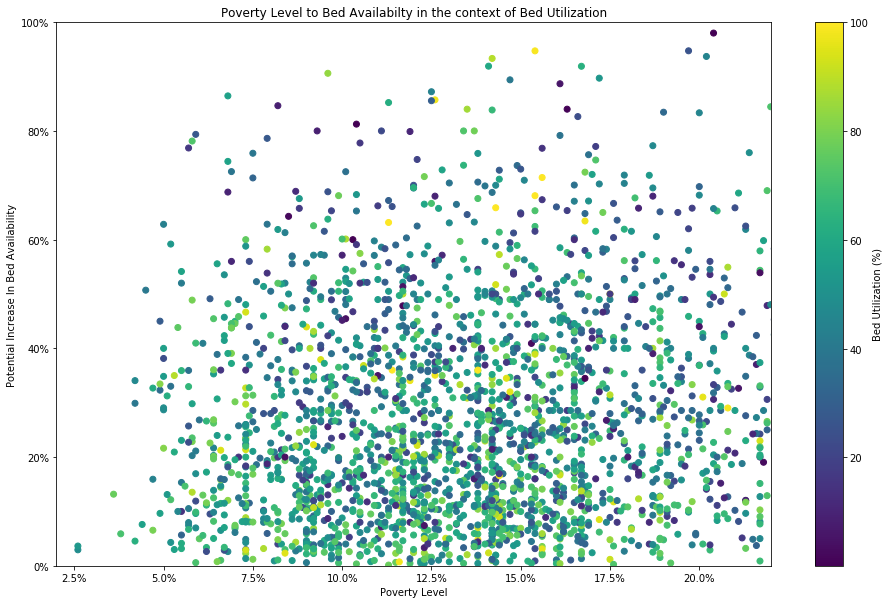

In [37]:
# Multivariate analysis on the postive relationship we found between increase in bed availability and poverty level.
fig,ax = plt.subplots(figsize = [16,10])
plt.scatter(data=pot_beds_df, x='PCT_POVALL_2018', y='PCT_POTNL_INC_BED_CAPC',
            c='PCT_BED_UTILIZATION',
            cmap = 'viridis'
            )

plt.xlim(2,22)
plt.ylim(0,100)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Bed Utilization (%)')
plt.xlabel('Poverty Level')
plt.ylabel('Potential Increase In Bed Availability')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter())
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.title('Poverty Level to Bed Availabilty in the context of Bed Utilization')
plt.show()


A strong positive relationship is shown from the above multivariate analysis as we see this thorugh the scatter plot between increase in bed availability and poverty level and as it aligns to bed utlization percentages.

In [38]:
# Saving the dataset to CSV for further analysis.
pot_beds_df.to_csv('poverty-beds-df.csv')

## Next steps - Explanatory Analysis ##

As next steps - to prove the above findings from pouplation data, I will answer the below questions:

How are top 5 states in poverty doing in terms of Bed utilization and availability with reference to the hosptial types?

- For this analysis, I have compared the mean and median values and found them to be close this is to help us handle the large variation that we found with the original data set.
- A subset data sets will be created to perform this analysis.
